# 8.4 The Camera model

Until now we have first focused in stating the mathematical tools required to understand general vector/coordinates transformations and then to apply them to perform different image transformations (homographies). In fact, remember that in previous notebooks, we have transformed `WORLD` coordinates to `CAMERA` coordinates and the other way around, but that is just a **3D to 3D** transformation. However, we have not properly addressed yet the process of transforming **`WORLD` coordinates (3D)** to **`IMAGE` coordinates (2D)** (and vice versa when possible), that is, how images are formed from real 3D objects. Well, this is the time, let's go for it!

In this notebook we will learn:

- the **big picture** of the problem that we are addressing (<a href="#841">section 8.4.1</a>), 
- the **Pinhole model** (<a href="#842">section 8.4.2</a>), and
- the **Camera model** (<a href="#843">section 8.4.3</a>).

Finally, we will put the learned concepts to work with a practical example (<a href="#844">section 8.4.4</a>).

## Problem context - RGB-D images

RGB-depth (RGB-D) images are just like standard RGB images (where each pixel has information about each basic color: red, green and blue) but adding another information to each pixel: **its distance from the camera to the 3D point that is projected on it**. That is, these images contain not only photometric information but also geometric information.$\\[10pt]$

<img src="./images/kinect.png" width="600"/>$\\[5pt]$

In this figure, the left image is the standard RGB image, while the right one is the *depth* band shown as a greyscale image (darker as the object is closer).

Although this kind of images have been used for some decades now, in recent years they have become popular due to the development of inexpensive sensors, such as the [Microsoft's Kinect](https://en.wikipedia.org/wiki/Kinect) camera, that are able to directly provide them. In the entertainment bussiness, these images have been used for segmenting the people using the system from the background of the image and inspecting their movements.

Roughly speaking, the working principle of these devices (called structured light) involves projecting an infrared pattern on the scene (see image below) and inspecting the deformations that such pattern undergoes due to the irregular surfaces where the light bounces. These deformations are directly related to the distance and position of the object.

<img src="./images/kinect_pattern.png" width="400"/>$\\[5pt]$

As RGB-D images actually provide depth information, they are a **good example for learning how image formation models work**, because we can turn images to 3D maps (using the depth) and the other way around (3D scene to 2D image plane).

## 8.4.1 The big picture <a id=841></a>

The process of converting **world coordinates** to **image coordinates** involves several steps that are applied by means of the concatenation of transformations expressed with homogeneous matrices/vectors. We address all these transformations in this notebook but, first, let's present the whole process in a single image, just to keep an eye on **the big picture** and then we will unravel its mysteries.

<center><figure>
    <img src="images/cameramodel.png" >$\\[5pt]$
    <figcaption>Fig. 1 - The big picture of the transformation involved in the conversion of a 3D point $M$ from its world coordinates to the image ones $m$.</figcaption>
</figure></center>

Let's do this step by step!

In [1]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats

from mpl_toolkits.mplot3d import Axes3D
from math import sin, cos, radians, floor
images_path = './images/'
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

import sys
sys.path.append("..")
from utils.plot3DScene import plot3DScene

### Homogeneous coordinates (again)

Apart from what we already know about homogeneous coordinates, an interesting property of them is that the **homogeneous coordinates of a point in the plane ($\mathbb{R}^2$) also represents a line passing through the origin in a reference frame parallel to the image plane**:$\\[10pt]$

<img src="./images/homogenous.png" width="400"/>$\\[5pt]$

That is, for a certain Cartesian point $\mathbf{p}=(x,y)$, its homogeneous version $\tilde{\mathbf{p}}=(kx,ky,k),\forall k$ represents a line in 3D starting at the origin of coordinates. This is called a **projection line**. 
 
The **projective plane**, called $\mathbb{P}^2$, is the set of 3-tuples of real numbers such that $\begin{bmatrix}x_1 \\ x_2 \\ 1\end{bmatrix} \equiv k \begin{bmatrix}x_1 \\ x_2 \\ 1\end{bmatrix}, \ k \ne 0$, that is the set of all projective lines at a certain distance $k$ from the origin of coordinates.

So, in summary:
- A point in $\mathbb{P}^2$ (3-tuple) is represented in ($\mathbb{R}^3$) as a line passing through the origin.
- The component $k$ can be understood as the *depth*, as it indicates a specific point along the line.
 

## 8.4.2 The Pinhole model <a id=842></a>

The Pinhole camera model is the simplest model we can think to understand how image formation works [[1]](https://web.stanford.edu/class/cs231a/course_notes/01-camera-models.pdf). Let’s image that we want to design a simple camera system that can record an image of an object in the 3D world. This camera system can be designed by placing a solid barrier with a small  (pin-size) aperture between the 3D object and a photographic film or sensor. 

<img src="./images/pinhole_intro.png" />$\\[5pt]$

As this figure shows, each point on the 3D object bounces the light from the source and emits multiple rays of such light outwards. Without a barrier in place, every point on the film will be influenced by light rays emitted from every point on the 3D object. However, due to the barrier, only one (or a few) of these rays of light passes through the aperture and hits the film. Therefore, we can establish a one-to-one mapping between points on the 3D object and the film. The result is that the film gets exposed by an *image* of the 3D object by means of this mapping. This simple model is known as **the pinhole camera model**.

In the Pinhole model we want to project the 3D world (a set of $\mathbf{p}_i=[X_i,Y_i,Z_i]^T$ points) in a plane called **image plane**. For that, we have a camera placed at $\mathbf{C} = [0,0,0]^\texttt{T}$ in the `WORLD` reference system (i.e. both the `WORLD` and the `CAMERA` systems are coincident). This camera has a fixed property $f$ called **focal length**, which indicates the distance between the the optical center and the **camera sensor** (placed in the interior of the camera). The camera sensor is the plane **where the scene of the real world is projected**:

<img src="./images/pinhole.png" />$\\[5pt]$

To operate with this image formation model, we need to know two processes: 
- to project a 3D world point to the image plane 
- to back-project a 2D point on the image plane to the 3D world.

For this, we are going to use the previously mentioned property of homogenous coordinates. Let's take a look at these processes!

### From 2D to 3D

Given a point $\mathbf{p} = [x,y]^\texttt{T} \in \mathbb{R}^2$ in the image, its **projection line** (in red in the figure above) in the camera system is very simple to compute by means of the line passing through the point $[x,y,f]^\texttt{T} \in \mathbb{R}^3$ (we have added the third component $f$ because the image plane is placed at a distance $f$ in the $Z$-axis of the camera reference system, recall that this is the **focal length**!). In homogeneous coordinates, this line follows the expression:$\\[5pt]$

$$k \begin{bmatrix}x \\ y \\ f \end{bmatrix} \in \mathbb{P}^2$$

where $k$ indicates a specific 3D point along the projection line, and $P$ is the so called **projective plane**.

For instance, if we set $k=2$ we have the point:$\\[5pt]$

$$ \begin{bmatrix}2x \\ 2y \\ 2f \end{bmatrix} \in \mathbb{R}^3 \\[5pt]$$

Note that, in this expression, $k$ does not correspond directly to the depth of the 3D point, but we can fix this dividing by the focal length:$\\[5pt]$

$$k' \begin{bmatrix} x/f  \\ y/f \\ 1 \end{bmatrix} \in \mathbb{P}^2 \\[5pt]$$ 

Now that the third coordinate is 1, $k'$ indicates the depth of the 3D point (that is, it's coordinate along the $Z$ axis), so that if we know that the depth of a pixel is 5, we only have to set $k'=5$ and we will have the 3D coordinates of the point.$\\[10pt]$

### From 3D to 2D
Let's have a look now at the process of projecting 3D points to 2D. Given any 3D point $\mathbf{M} = [X,Y,Z]^T \in \mathbb{R}^3$, we know that it has a projection point in the image plane $\mathbf{m} = [x,y]^T \in \mathbb{R}^2$.  

As seen before, the 3D point in the projection line of $\mathbf{m}$ with depth $Z$ is:$\\[5pt]$

$$Z \begin{bmatrix} x/f  \\ y/f \\ 1 \end{bmatrix} = \begin{bmatrix} Zx/f  \\ Zy/f \\ Z \end{bmatrix} \in \mathbb{R}^3 \\[5pt]$$ 

So that we can find the 2D image coordinates of the projected point through:$\\[5pt]$

$$M = \begin{bmatrix}X \\ Y \\ Z \end{bmatrix} =  \begin{bmatrix} Zx/f  \\ Zy/f \\ Z \end{bmatrix} \longrightarrow \begin{eqnarray} X = \frac{Zx}{f}\ \rightarrow \ x = \frac{fX}{Z} \\[3pt] Y = \frac{Zy}{f} \ \rightarrow \ y = \frac{fY}{Z} \end{eqnarray} \\[5pt]$$ 

This way, the relationship between the 3D point and its projected 2D point is like this:$\\[10pt]$
<img src="./images/3dto2d.png" />$\\[5pt]$

Note that this transformation is not linear, but **it becomes linear if we use homogenous coordinates!**:$\\[5pt]$

$$\begin{bmatrix} f & 0 & 0 & 0 \\ 0 & f & 0 & 0 \\ 0 & 0 & 1 & 0 \end{bmatrix}\begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} = \begin{bmatrix} fX \\ fY \\ Z\end{bmatrix} \xrightarrow{\text{homogenous to Cartesian}} \begin{bmatrix} fX \ / \ Z \\ fY \ / \ Z \end{bmatrix} \\[5pt]$$

### Summary

So, these equations relate 3D and 2D coordinates of a certain point in the real world and its projection in the image:

<img src="./images/pinhole_summary.png" />$\\[5pt]$

Note that it is impossible to get the complete 3D position of a certain point from its coordinates in a single image because we need to know the $Z$ coordinate beforehand. That is because the set of 3D points that falls in the line from the optical center to the image point **all of them project at the exact same point in the image**! This is also the reason why **we cannot determine the scale of the objects from a single image**, which is called the **scale indetermination** in monocular vision.

Usually, this transformation is made more general by decomposing it as $Z \tilde{\mathbf{m}} = \mathbf{K}_f\underbrace{\mathbf{P}_0\tilde{\mathbf{M}}_C}_{Z\tilde{\mathbf{m}}_1}\\[5pt]$, that is:

$$Z \underbrace{\begin{bmatrix} x  \\ y \\ 1 \end{bmatrix}}_{\tilde{\mathbf{m}}} = \underbrace{\begin{bmatrix} f & 0 & 0\\ 0 & f & 0  \\ 0 & 0 & 1\end{bmatrix}}_{\mathbf{K}_f}\underbrace{\begin{bmatrix} 1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0  \\ 0 & 0 & 1 & 0\end{bmatrix}}_{\mathbf{P}_0 = [\mathbf{I}|\mathbf{0}]}\begin{bmatrix} X  \\ Y \\ Z \\ 1 \end{bmatrix}$$

In this expression, called **perspective projection equation**, $\tilde{\mathbf{m}}$ is the homogeneous 2D point, $\mathbf{K}_f$ is called the **calibration matrix** and $\mathbf{P_0}$ represents a certain transformation between the `CAMERA` and the `WORLD` reference system, as we will see later. The image below further illustrate these relations:

<img src="./images/3dto2d-2.png"/>$\\[5pt]$

### **<span style="color:green"><b><i>ASSIGNMENT 1: From world to image coordinates using the Pinhole model</i></b></span>**

**Your first task is** to transform a number of points expressed in `WORLD` coordinates into image ones. You have to consider that:

- The world points are given in the  `world` matrix,
- both the `WORLD` and the `CAMERA` systems are coincident,
- the focal length of the camera is $f = 2.5$, and
- you should use **only** linear transformations and express the result in **Cartesian coordinates**.

[[ -3.      7.5   -37.5     7.885  41.875 -19.286  16.5    -4.     14.375
  -20.714]
 [  5.25   -9.286 -42.5     4.423 -26.25  -23.929  38.     -9.     13.125
  -13.214]]


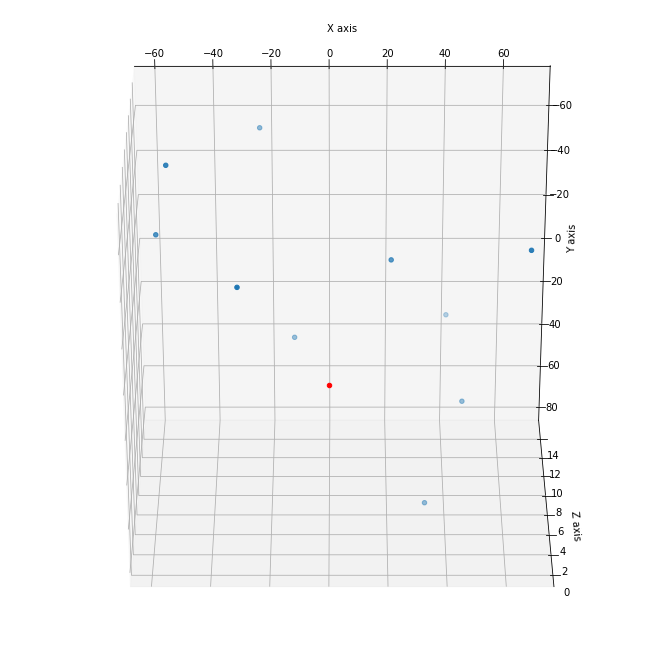

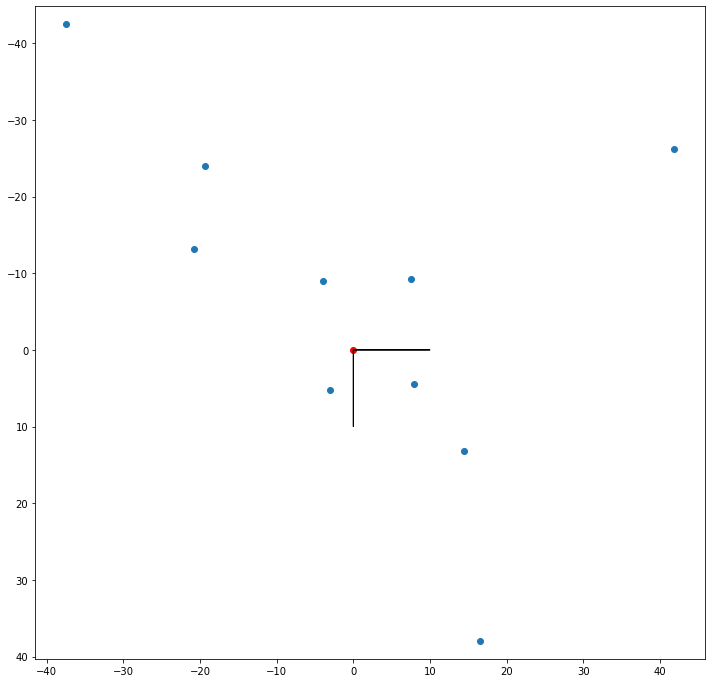

In [3]:
# %matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

# ASSIGNMENT 1 --
# World coordinates
world = np.array([[-12, 21,-30,41, 67,-54,33,-24,46,-58],  # X
                  [ 21,-26,-34,23,-42,-67,76,-54,42,-37],  # Y 
                  [ 10,  7,  2,13,  4,  7, 5, 15, 8,  7]]) # Z

# world = np.array([[12,21,30,41,67,54,33,24,46,58],[21,26,34,23,42,67,76,54,42,37],[10,7,2,13,4,7,5,15,8,7]])
# world = np.array([[-12,-21,30,41,-67,54,-33,24,46,-58],[21,-26,34,-23,42,-67,76,-54,-42,37],[10,7,3,13,4,7,5,15,8,7]])

# Create figure
fig = plt.figure()

# Prepare figure for 3D data
ax = fig.gca(projection='3d')
# print(ax.dist)
# ax.view_init(azim=-60,elev=-30)

# Name axes
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Plot points
ax.scatter(world[0,:], world[1,:], world[2,:])
ax.scatter(0, 0, 0, color="red")
ax.view_init(elev=-60, azim=-90)

# Focal length
f = 2.5

# Convert world coordinates to homogenous
h_world = np.append(world, np.ones((1,world.shape[1])), axis= 0)

# Define transformation matrices
K_f = np.array([[f,0,0],[0,f,0],[0,0,1]])

P_0 = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])

# Get sensor homogenous coordinates (apply transformation matrices)
h_sensor = K_f @ P_0 @ h_world

# Transform them to cartesian
sensor = h_sensor[:2,:] / h_sensor[2,:]

# For checking if the result is right
print(sensor.round(3))

# Create figure
fig = plt.figure()

# Prepare figure
ax = fig.gca()

# Plot points
ax.scatter(sensor[0,:], sensor[1,:])
ax.scatter(0, 0, color="red")
ax.arrow(0,0,10,0)
ax.arrow(0,0,0,10)
ax.axis('equal')
ax.invert_yaxis() # to make the plot show the 'y' axis downwards

**Check if your results are correct**:

<font color='blue'>**Expected output:**  </font>

    [[ -3.      7.5   -37.5     7.885  41.875 -19.286  16.5    -4.     14.375  -20.714]
     [  5.25   -9.286 -42.5     4.423 -26.25  -23.929  38.     -9.     13.125  -13.214]]

## 8.4.3 The Camera model <a id=843></a>

The Pinhole model is a useful starting point for understanding the processes of image formation, but it still has several limitations because:

- the camera frame point $m$ has its coordinates expressed **in meters** within the camera sensor, but we want to know them in **pixels**.
- it assumes that the `CAMERA` and the `WORLD` reference systems **are coincident**, which, of course, is not generally the case.

This is where we define the **camera model**, which includes some linear transformations for solving these limitations and allows us to address the complete problem of image formation as depicted in the big picture shown before:$\\[10pt]$

<img src="images/cameramodel.png">$\\[5pt]$

Let's go step by step!

### Step 1: From the `WORLD` frame to the `CAMERA` frame

This transformation implies finding a rotation matrix $\mathbf{R}$ and a translation vector $\mathbf{t}$ that **relates the position and orientation of the camera w.r.t. the world**. This is a 3D to 3D transformation and we have used it in the previous notebooks.

<img src="images/world_camera.png">$\\[5pt]$

As said before, usually the camera is not at the world center, mainly because the camera will move within the world, or even because will be more than one camera in our perception system.

Remember that in the second notebook of this chapter, we learned how to apply a rotation and a translation to a set of 3D points using homogeneous transformations:$\\[5pt]$

$$\mathbf{M}_C = \mathbf{R}\mathbf{M}_W + \mathbf{t} \ \xrightarrow{\text{In homogenous}} \ \tilde{\mathbf{M}}_C = \mathbf{D} \tilde{\mathbf{M}}_W$$

If we add this transformation to the Pinhole model, the new **perspective projection equation** takes the expression:

$$\lambda \tilde{\mathbf{m}} = \mathbf{K}_f \mathbf{P}_0 \tilde{\mathbf{M}}_C = \mathbf{K}_f \mathbf{P}_0 \mathbf{D} \tilde{\mathbf{M}}_W$$

which allow us to transform points in 3D within the `WORLD` reference system (in meters) to points in 2D in the image sensor (**also in meters!**).

### Step 2: From the sensor image to a computer image

Once we have obtained the sensor image points, we want to get the **image matrix coordinates** of such points **in pixels** (that is, *row and column* within the image matrix), which are the units we use in the computer in all the artificial vision processes we have studied in this book.$\\[10pt]$

<img src="images/sensor_matrix.png">$\\[5pt]$

As you can see in the figure, both images are related by an **affine** transformation (i.e. a 2D homography as seen in the previous notebook). As we know, affine transformations allow **rotation + translation + scale** (different for each axis). In this case we don't need any rotation, but axes **do scale**, and such scale represents the size in meters in the sensor of each pixel in the image:

$$\mathbf{m}' = \mathbf{A}\mathbf{m} + \mathbf{b} = \begin{bmatrix}k_x & 0 \\ 0 & k_y\end{bmatrix}\underbrace{\begin{bmatrix} x \\ y \end{bmatrix}}_{\text{meters}} + \underbrace{\begin{bmatrix} u_0 \\ v_0 \end{bmatrix}}_{\text{pixels}} \xrightarrow{\text{In homogenous}} \begin{bmatrix} u \\ v\\ 1 \end{bmatrix} = \begin{bmatrix} k_x & 0 & u_0  \\ 0 & k_y & v_0 \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ y\\ 1 \end{bmatrix} \qquad \bf{\tilde{\mathbf{m}}' = \mathbf{K}_s \tilde{\mathbf{m}}}$$

Note that in this expression, $k_x$ and $k_y$ determine the scale and have units of **pixels/meter**, while $u_0$ and $v_0$ are the coordinates of the **principal point**, which is the projection of the $Z$ axis in the image plane. These elements are part of the **intrinsic parameters** of the camera, which means that they are always **constant** for the same camera.

### **<span style="color:green"><b><i>ASSIGNMENT 2: From image coordinates to pixels</i></b></span>**

It is time to transform the sensor coordinates (in meters) obtained in the previous assignment to proper image coordinates (in pixels). For this, you will need the intrinsic parameters of the camera, which for this example are: 

- `k_x = 2`
- `k_y = 3`
- `u_0 = 300`
- `v_0 = 200`

Don't worry, these values are normally provided by the manufacturer of the camera, although not everything is lost otherwise. We could also calculate them through a process called **camera calibration**, which we will address in the next chapter. Exciting!

Concretely, **you have to**:
- define the homography $\mathbf{K}_s$ (`H` in the code) relating meters with pixels,
- apply it to the sensor coordinates in `h_sensor` as retrieved in the previous assignment, 
- transform the resulting coordinates to Cartesian ones, and
- show them!

[[294 315 225 315 383 261 333 292 328 258]
 [215 172  72 213 121 128 314 173 239 160]]


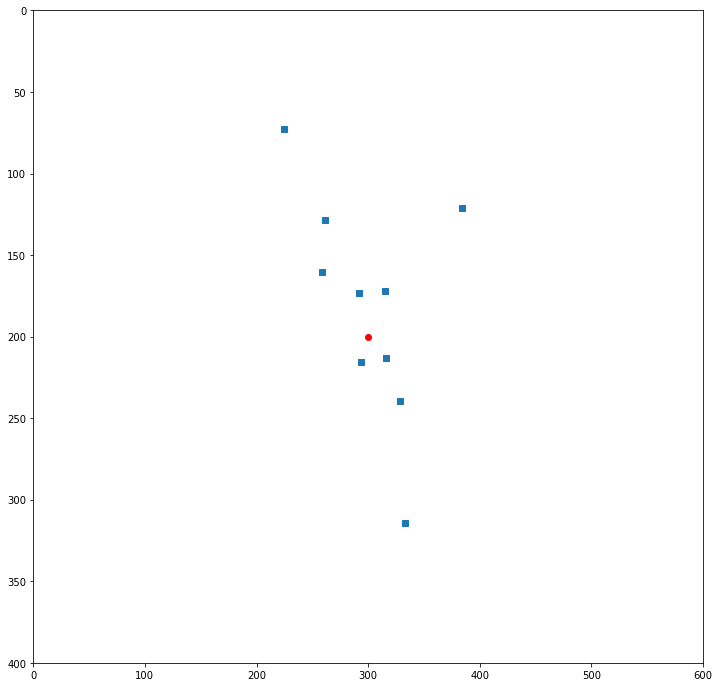

In [4]:
# ASSIGNMENT 2 --
# Define intrinsic parameters
kx = 2 
ky = 3 
u0 = 300 
v0 = 200

# Write your code here!

# Transformation matrix
H = np.array([[kx, 0, u0],[0,ky,v0],[0,0,1]])

# Transform sensor coordinates to image coordinates
h_image_pixels = H @ h_sensor
center = H @ np.array([0,0,1])

# Transform to cartesian
image_pixels = h_image_pixels[:2,:] / h_image_pixels[2,:]

# For checking if the result is right
print(image_pixels.astype(int))

# Create figure
fig = plt.figure()

# Prepare figure for 3D data
ax = fig.gca()

# Plot points
ax.scatter(image_pixels[0,:], image_pixels[1,:], marker='s')
ax.scatter(center[0], center[1], color="red")

# Set axes limits
ax.set_xlim(0, 600)
ax.set_ylim(0, 400)
#ax.axis('equal')
ax.invert_yaxis() # to make the plot show the 'y' axis downwards

You can **check if your results are correct**:

<font color='blue'>**Expected output:**  </font>

    [[294 315 225 315 383 261 333 292 328 258]
     [215 172  72 213 121 128 314 173 239 160]]

### General form of the Perspective matrix

Let's see how the final perspective transformation would be **from 3D world frame to computer image**:

$$\lambda \begin{bmatrix} u \\ v\\ 1 \end{bmatrix} = \underbrace{\begin{bmatrix} k_x & 0 & u_0  \\ 0 & k_y & v_0 \\ 0 & 0 & 1 \end{bmatrix}}_{\text{from sensor to image}}\underbrace{\begin{bmatrix} f & 0 & 0  \\ 0 & f & 0 \\ 0 & 0 & 1 \end{bmatrix}\begin{bmatrix} 1 & 0 & 0 & 0  \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \end{bmatrix}}_{\text{from camera frame to sensor}}\underbrace{\begin{bmatrix} \bf{R} & \bf{t}  \\ \bf{0^T_3} & 1 \end{bmatrix}}_{\text{from world to camera frame}} \begin{bmatrix} X_W \\ Y_W\\ Z_W \\ 1 \end{bmatrix}$$

Again, we can merge some transformations:

$$\lambda \begin{bmatrix} u \\ v\\ 1 \end{bmatrix} = \begin{bmatrix} f k_x & 0 & u_0  \\ 0 & f k_y & v_0 \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} \bf{R} & \bf{t}\end{bmatrix} \begin{bmatrix} X_W \\ Y_W\\ Z_W \\ 1 \end{bmatrix} \qquad \bf{\lambda \tilde{m}' = K \left[ R\ t \right] \tilde{M}_W}$$

where 
- $\bf{R}$ and $\bf{t}$ are **extrinsic** paremeters that depend on the camera position.
- $f$, $\ k_x$, $\ k_y$, $\ u_0$ and $v_0$ are **intrinsic** parameters (constant) that depend on the camera that is being used.

*Note: you will usually find that $f$ is directly expressed in pixels, so actually it will be the result of $fk_x$ and $fk_y$, and furthermore, this is sometimes also called $fk_x = s_x$ and $fk_y = s_y$*

Here you have the full camera model in action:$\\[10pt]$

<img src="images/camera_model.png" width="700">$\\[5pt]$

**For a visual explanation of this model, you can check** [this interactive application](http://ksimek.github.io/2012/08/22/extrinsic/).

## 8.4.4 Putting things to work: the RGB-D  image <a id="844"></a>
 
As a practical exercise, we are going to apply the pinhole camera model to get a 3D set of points (also known as a **pointcloud**) from an RGB-D image. Remember that we said that it is not possible to determine the 3D position of a point from just its coordinates in a single image? Well, in this case we have **the depth information** included in the image and therefore we can now accomplish that! So, let's transform 2D points in the RGB image to 3D points in the world frame.

### **<span style="color:green"><b><i>ASSIGNMENT 3a: Visualizing our RGB-D image</i></b></span>**

First of all, show the RGB-D image in a 2x1 subplot with the RGB part in the left (`person_rgb.png`) and the depth part in the right (`person_depth.png`) and see what they look like.

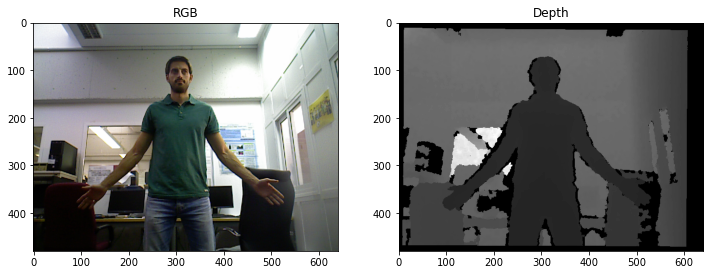

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

# ASSIGNMENT 3a --
# Write your code here!

# Read images
image = cv2.imread(images_path + 'person_rgb.png', -1)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
depth = cv2.imread(images_path + 'person_depth.png', 0)

# Show RGB
plt.subplot(121)
plt.title("RGB")
plt.imshow(image)

# Show depth
plt.subplot(122)
plt.title("Depth")
plt.imshow(depth,cmap="gray");

### From the RGB-D image to 3D coordinates 

As you can see, the depth image represents the depth with levels of grey color, the darker it is a pixel, the closer to the camera it is. So, for each pixel **there is a mapping between intensity $\rightarrow$ depth**. Since we have the actual depth of the points, we just need to get the projection lines of the pixels in the image and then select the Z of the point according to the depth.

First, we need to transform the points in **image coordinates** to **sensor coordinates**. For this, we reverse the sensor to image method seen previously, either by using the pseudoinverse matrix or by **isolating the variables**.

We know that *(assuming that the scale is 1)*:

$$\bf{2D \rightarrow 2D} \qquad \underbrace{\begin{bmatrix} u \\ v\\ 1 \end{bmatrix}}_{\text{pixels}} = \begin{bmatrix} f & 0 & u_0  \\ 0 & f & v_0 \\ 0 & 0 & 1 \end{bmatrix} \underbrace{\begin{bmatrix} x \\ y\\ 1 \end{bmatrix}}_{\text{meters}}$$

If we isolate $x$ and $y$, we get the coordinates in the sensor:

$$\begin{eqnarray} x = \frac{u-u_0}{f}, \; y = \frac{v-v_0}{f} \end{eqnarray}$$

Finally, we add the depth component $Z$, which it's available in the depth image:

$$\bf{3D \rightarrow 2D} \; \ \text{for} \; \ k=1 \; \text{so} \; Z=f\quad \begin{bmatrix} X \\ Y\\ Z \end{bmatrix} = Z \begin{bmatrix} x \\ y\\ 1 \end{bmatrix}$$

so $X=Zx$ and $Y=Zy$.

### **<span style="color:green"><b><i>ASSIGNMENT 3b: Building a point cloud from an RGB-D image</i></b></span>**

Generate a $[3\times N]$ matrix with the 3D camera frame coordinates of all pixels in the image `person_rgb.png` using these intrinsic parameters:

- `f = 525`
- `k_x = 1`
- `k_y = 1`
- `u_0 = 319.5`
- `v_0 = 239.5`

Notice that we are using a linear scale that discretizes the camera operating range, from 0 up to 5 meters, in order to encode such distances in the 256 pixel possible values of a greyscale image. In this way, `scale=0.02` (approx. $5m/256$) so, for example, if the value of a pixel in the depth image is 20, it means that its corresponding 3D point is `20*scale=0.4` meters away.

In [6]:
# Read images
image = cv2.imread(images_path + "person_rgb.png",-1)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
depth = cv2.imread(images_path + "person_depth.png",0)

# Import intrinsic parameters
f  = 525
u0 = 319.5
v0 = 239.5

# Matrix for storing (homogeneous) sensor coordinates
h_sensor = np.zeros((3,image.shape[0]*image.shape[1]))

# Get sensor coordinates in meters
point = 0
for v in range(image.shape[0]): # rows
    for u in range(image.shape[1]): # columns
        # Transform to sensor coordinates
        h_sensor[0,point] = (u-u0)/f
        h_sensor[1,point] = (v-v0)/f
        h_sensor[2,point] = 1 # Homogeneous coordinates
        point += 1
        
scale = 0.02 # ~5m/256 
image_d_fila = np.reshape(depth,(1,depth.shape[0]*depth.shape[1]))
image_d_fila = image_d_fila*scale

map_3d = h_sensor * image_d_fila # element-wise multiplication

# check coordinates at points 100060, 100061 and 100062
print(map_3d[:,100060:100063])

[[-0.30702857 -0.30394286 -0.30085714]
 [-0.25765714 -0.25765714 -0.25765714]
 [ 1.62        1.62        1.62      ]]


You can **check if your results are correct** (Positions of the points nº 100060, 100061 and 100062 in the camera frame):

<font color='blue'>**Expected output:**  </font>

    [[-0.30702857 -0.30394286 -0.30085714]
     [-0.25765714 -0.25765714 -0.25765714]
     [ 1.62        1.62        1.62      ]]

This is what you should get:

<img src="images/pointcloud.png" >$\\[5pt]$

You can see how all the pixels in the image have been back-projected to 3D and we have a fancy pointcloud showing our scene in 3D. Now all those points are in the `WORLD` reference system (we assumed that `WORLD`and `CAMERA` reference systems were coincident) and we can move our camera in order to get an image from a different perspective. Let's go for it.

<IPython.core.display.Javascript object>


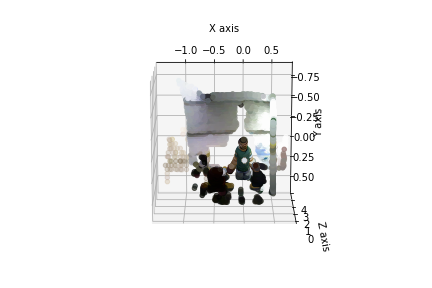

In [7]:
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

# Let's draw the pointcloud!
%matplotlib notebook
plot3DScene(map_3d,image)

This is what you should get:

<img src="images/pointcloud.png" >$\\[5pt]$

You can see how all the pixels in the image have been back-projected to 3D and we have a fancy pointcloud showing our scene in 3D. Now all those points are in the `WORLD` reference system and we can move our camera in order to get an image from a different perspective. Let's go for it.

### Moving the camera and observing the scene

So, in this last part of this practical exercise we are going to move the camera position and project the pointcloud again to form a new 2D image of it. This implies:
- there is a rotation and translation between the `WORLD` and `CAMERA` reference systems, so we need to compute the point coordinates in the latter,
- then, we need to project those points to the sensor plane,
- then, we need to scale and translate such points in the sensor plane to an *computer image plane*,
- and finally, we need to adjust their coordinates to get the image plane with origin at the top-left.

Therefore, you should use the full projective transformation from the world reference frame to the image:

$$\lambda \begin{bmatrix} u \\ v\\ 1 \end{bmatrix} = \begin{bmatrix} f  & 0 & u_0  \\ 0 & f  & v_0 \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} \bf{R} & \bf{t}\end{bmatrix} \begin{bmatrix} X_W \\ Y_W\\ Z_W \\ 1 \end{bmatrix} \qquad \bf{\lambda \tilde{m}' = K \left[ R\ t \right] \tilde{M}_W}$$

### **<span style="color:green"><b><i>ASSIGNMENT 3c: Taking a picture</i></b></span>**

Let's change the pose `CAMERA` in the `WORLD` reference system and take a new picture of the 3D scene. For that: 

- Define a rotation of $15º$ in the $Y$ axis and a translation of $0.5m$ in the $Z$ axis to move the camera. 
- Then, apply the complete camera model to the previous computed 3D pointcloud `h_map3D`.
- Iterate over the projected points for checking if they must appear in the image:
    - their $u$ and $v$ coordinates are within the image dimensions, and
    - since multiple points can be projected into the same pixel, keep the point that is closer to the camera.
- Finally, show the original image and the new one!

In [12]:
%matplotlib inline

# intrinsic parameters
f  = 525
u0 = 319.5
v0 = 239.5

# Define transformation matrices
angle = np.radians(15)
R = np.array([[1,0,0],[0,1,0],[0,0,1]])@np.array([[cos(angle),0,sin(angle)],[0,1,0],[-sin(angle),0,cos(angle)]]) # rotation

T = np.zeros((3,4))
T[0:3,0:3] = R
T[0:3,3] = [0,0,.5] # translation

K = np.array([[f,0,u0],[0,f,v0],[0,0,1]])

# Transform map to homogenous coordinates
h_map3D = np.append(map_3d, np.ones((1,map_3d.shape[1])), axis=0)

# Apply transformation
h_new_image = K @ T @ h_map3D

# Transform to cartesian (they may appear zeroes in z!)
proj = np.divide(h_new_image[:2,:], h_new_image[2,:], where=h_new_image[2,:]!=0)
proj[np.isnan(proj)] = 0 # Fix division by 0
proj = proj.astype(int)

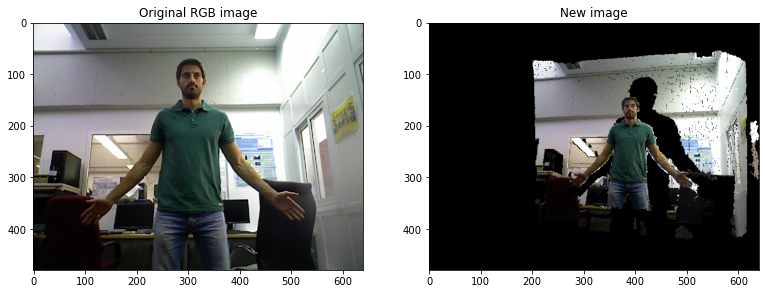

In [13]:
# Construct new image
new_image = np.zeros_like(image)
new_depth = np.full(depth.shape,np.inf)

image_vector = image.reshape(image.shape[0]*image.shape[1],3) # this is a Nx3 vector with the all pixels in RGB

# iterate over the projected points and check if they must appear in the image
for p in range(proj.shape[1]):
        u,v = proj[:,p]        
        z = h_map3D[2,p] # z-coordinate
        # Should this pixel appear in the image?
        if (u>=0) and (u<new_image.shape[1]) and (v>=0) and (v<new_image.shape[0]): # Check if pixel is in bounds
            if (new_depth[v,u] > z): # Check if pixel is closer than other in that position
                new_depth[v,u] = z
                new_image[v,u,:] = image_vector[p,:] # Get the color
            
# Show original image
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(13, 13))
ax1.imshow(image)
ax1.set_title("Original RGB image")
ax2.imshow(new_image)
ax2.set_title("New image");

This is the resulting image you should have obtained:

<img src="images/new_render.png">$\\[5pt]$

You can see how now we have a new perspective of the point cloud! Cool, right?

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

**Now you are in a good position to answer these questions:**

- If we have a RGB-D camera with an operating range from 0 up to 10 meters, what would be the scale used to codify distances in a greyscale image?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Como la imagen usa un rango de operación 0-5 la escala deberá hacer posible que se extienda el doble, hasta cubrir desde 0 a 10 metros. </i></p>
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Por lo tanto, la escala debe ser 2.</i></p>
    
- If the scale is of 0,01, which would be the maximum operating range? Assume that the operating range starts at 0.

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>0,01 * 256 = 2,56 metros. Esto es debido a que la distancia entre cada pixel tiene como rango 0-256.</i></p>
  
- The following image have been taken with the camera rotated in the $Y$ axis. Which has been the rotated angle? $30º$ or $-30ª$?

    <img src="images/new_render_y_30.png">$\\[5pt]$
    
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>La rotación hacia la izquierda es debida a ángulos de rotación negativos, por lo que se ha aplicado con -30º</i></p>

## Conclusion

Brilliant! Although this has been a dense chapter, it has been satisfying once you get it. In this notebook, you have learned:

- the principle of RGB-D images (widely used in computer vision and robotics fields nowadays),
- how the pinhole camera model works,
- how a more complete camera model works,
- how to project a 3D set of points to a 2D image,
- how to back-project an image with depth information to the 3D space to get a pointcloud.